In [1]:
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt

# 1: Basic 1D histogram

Let's start with the basics. We will create a histogram using boost-histogram and fill it.

## 1.1: Data

Let's make a 1d dataset to run on.

In [2]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000)

Now, let's make a histogram

In [3]:
hist1 = bh.Histogram(bh.axis.Regular(40, -2, 10))

In [4]:
hist1.fill(data1)

Histogram(Regular(40, -2, 10), storage=Double()) # Sum: 981493.0 (1000000.0 with flow)

You can see that the histogram has been filled. Let's explicitly check to see how many entries are in the histogram:

In [5]:
hist1.sum()

981493.0

What happened to the missing items? They are in the underflow and overflow bins:

In [6]:
hist1.sum(flow=True)

1000000.0

We have overflow bins by default. We can turn them off, but they enable some powerful things like projections.

Let's plot this (Hist should make this easier):

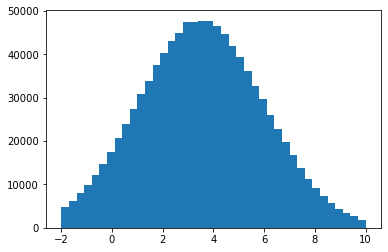

In [7]:
plt.bar(hist1.axes[0].centers, hist1.view(), width=hist1.axes[0].widths);

Note: You can leave off the `.view()` if you want to - histograms conform to the buffer protocol. Also, you can select the axes before or after calling `.centers`; this is very useful for ND histograms.

From now on, let's be lazy

In [8]:
plothist = lambda h: plt.bar(h.axes[0].centers, h, width=h.axes[0].widths

Aside: here's step. It's quite ugly for us out of the box in matplotlib, just like it is for numpy.

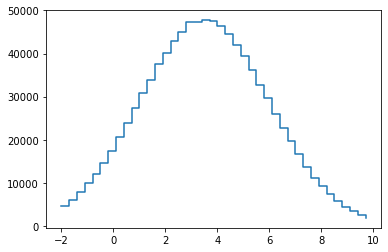

In [9]:
plt.step(hist1.axes[0].edges[:-1], hist1, where='post');

No plotting is built in, but the data is easy to access.

## 1.2: Drop-in replacement for Numpy

To start using this yourself, you don't even need to change your code. Let's try the numpy adapters.

> TODO: Move this to the beginning

In [10]:
bins2, edges2 = bh.numpy.histogram(data1, bins=10)

In [11]:
b2, e2 = np.histogram(data1, bins=10)

In [12]:
bins2 - b2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
e2 - edges2

array([ 0.00000000e+00,  8.88178420e-16,  8.88178420e-16, -8.88178420e-16,
       -8.88178420e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.77635684e-15, -1.77635684e-15,  0.00000000e+00])

Not bad!

Let's check performance:

In [20]:
%%timeit
_,_ = np.histogram(data1, bins=100)

8.16 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit
_,_ = bh.numpy.histogram(data1, bins=100)

3.88 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's start moving to the boost-histogram API, so we can use our little plotting function:

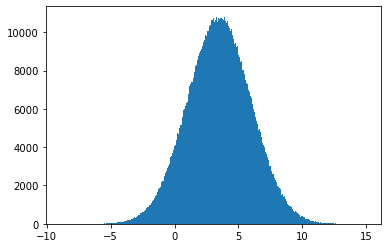

In [14]:
hist2 = bh.numpy.histogram(data1, bins='auto', histogram=bh.Histogram)
plothist(hist2);

Now we can move over to boost-histogram one step at a time! Just to be complete, we can also go the other direction:

In [15]:
b2p, e2p = bh.numpy.histogram(data1, bins=10, histogram=bh.Histogram).to_numpy()
b2p == b2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## 1.3: Making a density histogram

Let's try to make a density histogram like Numpy's.

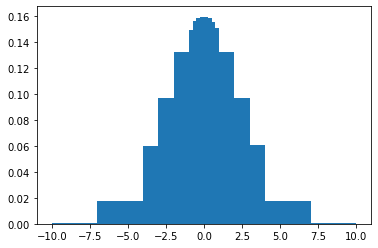

In [16]:
bins = [-10, -7, -4, -3, -2, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 2, 3, 4, 7, 10]
d7, e7 = np.histogram(data1 - 3.5, bins=bins, density=True)
plt.hist(data1 - 3.5, bins=bins, density=True);

Yes, it's ugly. Don't judge.

Density is not supported yet! What do we do?

In [17]:
hist7 = bh.numpy.histogram(data1 - 3.5, bins=bins, histogram=bh.Histogram)

widths = hist7.axes.widths
area = np.prod(widths, axis=0)

area

array([3.  , 3.  , 1.  , 1.  , 1.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 1.  , 1.  , 1.  , 3.  , 3.  ])

Yes, that does not need to be so complicated for 1D, but it's general.

In [18]:
factor = np.sum(hist7.view())
view = hist7.view() / (factor * area)

Setting with array support would make this simpler, and is will be shown here later (DRAFT).

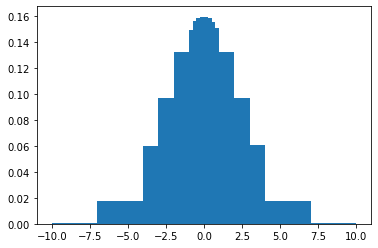

In [19]:
plt.bar(hist7.axes[0].centers, view, width=hist7.axes[0].widths);